In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import lightgbm as lgb

In [3]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv("Fraud.csv") 

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [9]:
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [10]:
df.isnull().sum().sum()  #general numbers of null values

0

In [11]:
df.shape

(6362620, 11)

In [12]:
round((df["isFraud"].value_counts()[1]/df.shape[0]) * 100, 2)  #percentage of fraud

0.13

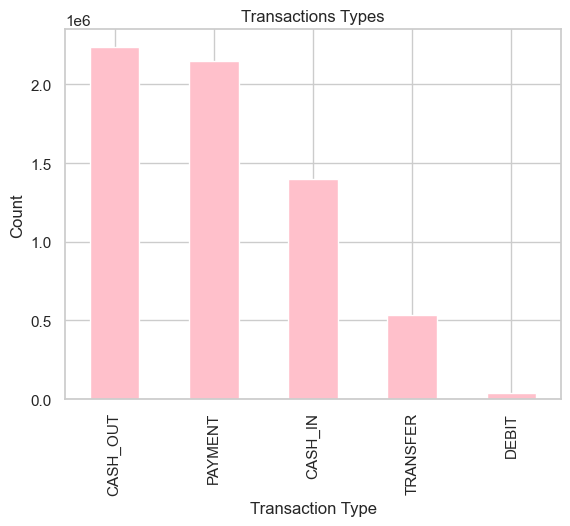

In [13]:
df["type"].value_counts().plot(kind="bar", title="Transactions Types" , color="Pink")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

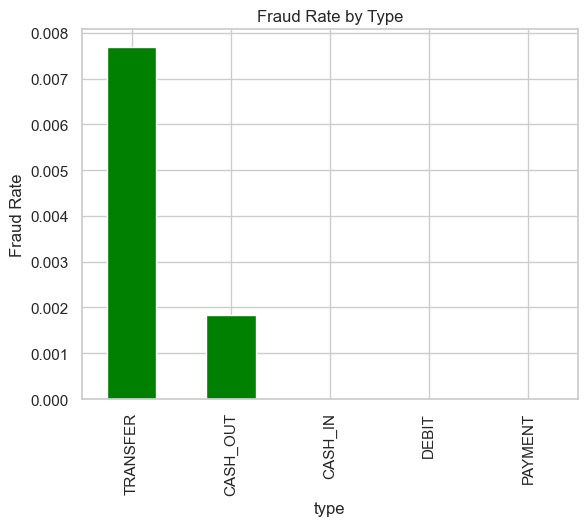

In [14]:
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar",title="Fraud Rate by Type", color="green")
plt.ylabel("Fraud Rate")
plt.show()

In [15]:
df["amount"].describe().astype(int)  # .astype(int) to convert scientific to int

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

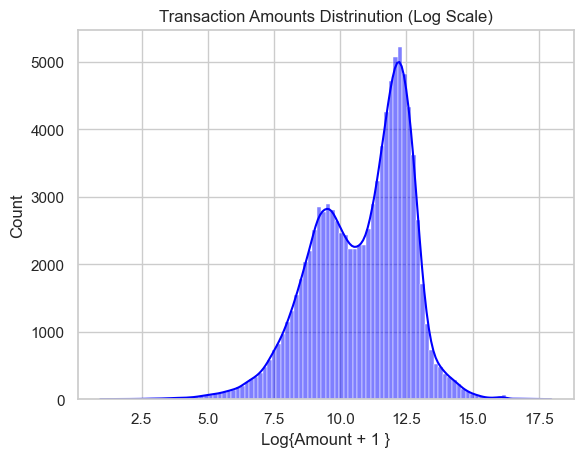

In [16]:
sns.histplot(np.log1p(df["amount"].sample(100000)), bins=100, kde=True, color="blue")
plt.title("Transaction Amounts Distrinution (Log Scale)")
plt.xlabel("Log{Amount + 1 }")
plt.show()

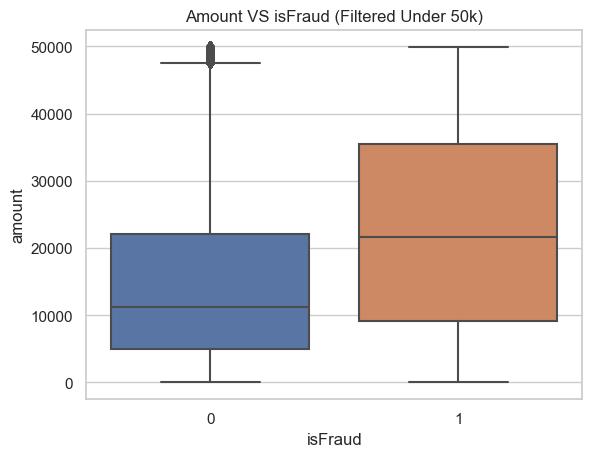

In [17]:
sns.boxplot(data=df[df["amount"] < 50000], y="amount", x="isFraud")
plt.title("Amount VS isFraud (Filtered Under 50k)")
plt.show()

In [18]:
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [19]:
(df["balanceDiffOrig"] < 0).sum()

1399253

In [20]:
(df["balanceDiffDest"] < 0).sum()

1238864

In [21]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


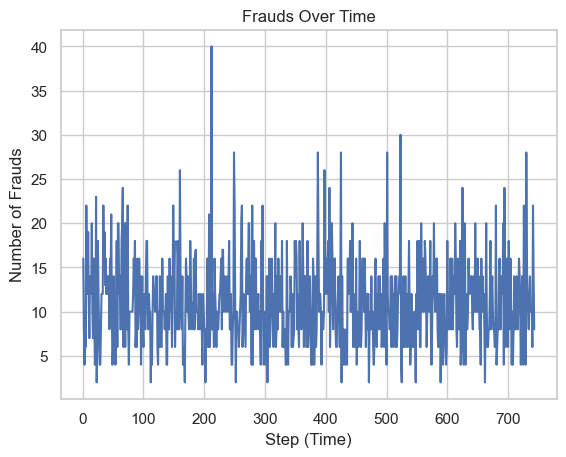

In [22]:
fraud_per_step = df[df["isFraud"] ==1]["step"].value_counts().sort_index()
plt.plot(fraud_per_step.index, fraud_per_step.values, label="Frauds per Step")
plt.xlabel("Step (Time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()

In [23]:
df.drop(columns="step", inplace=True)
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [24]:
top_senders = df["nameOrig"].value_counts().head(10)
top_senders

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [25]:
top_receivers = df["nameDest"].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [26]:
fraud_users = df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

In [27]:
fraud_types = df[df["type"].isin(["TRANSFER","CASH_OUT"])]
fraud_types["type"].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

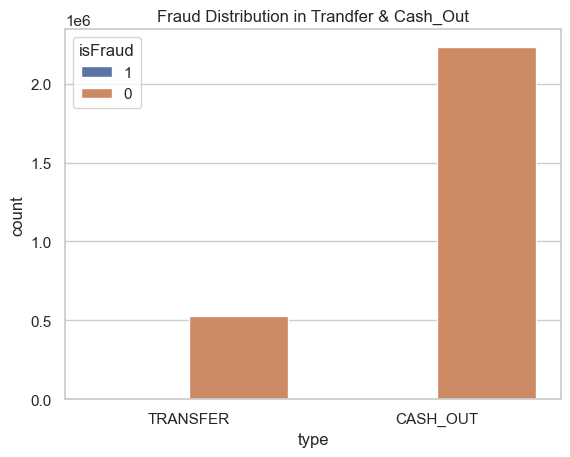

In [28]:
sns.countplot(data=fraud_types, x="type", hue=fraud_types["isFraud"].astype(str))
plt.title("Fraud Distribution in Trandfer & Cash_Out")
plt.show()

In [29]:
corr= df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFraud"]].corr()
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


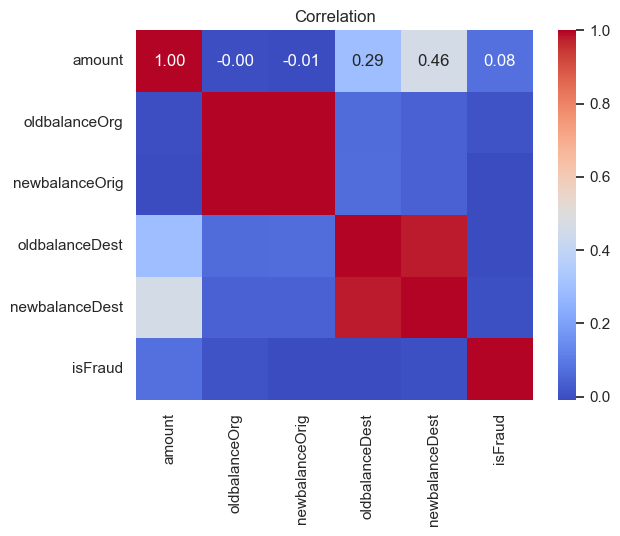

In [38]:
sns.heatmap(corr,annot=True,cmap = "coolwarm",fmt=".2f")
plt.title("Correlation")
plt.show()

In [52]:
scaler = StandardScaler()
scaled_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

In [61]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'learning_rate': 0.05,
    'max_depth': -1,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'seed': 42
}
model = lgb.train(params, train_data, num_boost_round=200)


[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1792
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651247
[LightGBM] [Info] Start training from score -6.651247


In [62]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [63]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270881
           1       0.07      0.98      0.12      1643

    accuracy                           0.98   1272524
   macro avg       0.53      0.98      0.56   1272524
weighted avg       1.00      0.98      0.99   1272524

Confusion Matrix:
 [[1248274   22607]
 [     33    1610]]
AUC Score: 0.9775693292060581


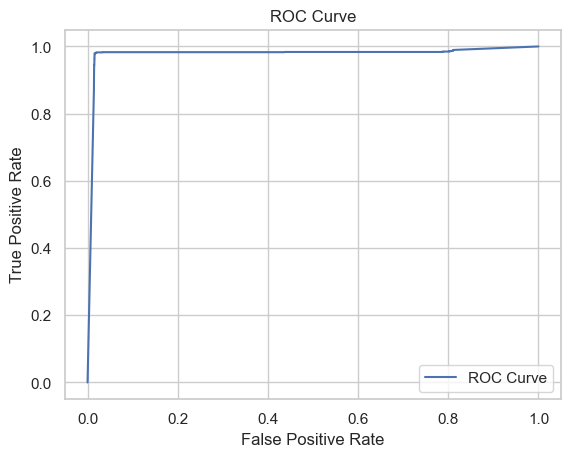

In [64]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [65]:
importance = model.feature_importance()
features = X.columns
feat_imp = pd.Series(importance, index=features).sort_values(ascending=False)

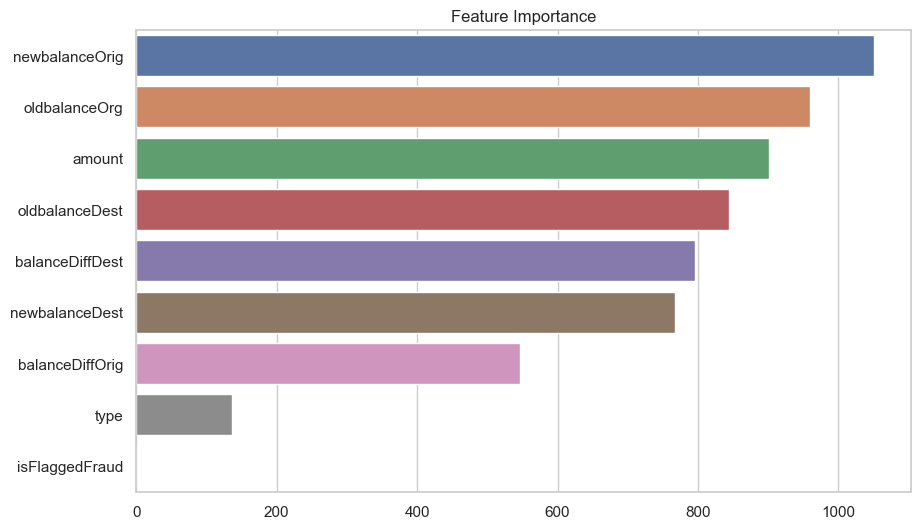

In [66]:
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance")
plt.show()